## Using SARIMA to forecast American Airline Group Inc. (AAL)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

[*********************100%***********************]  1 of 1 completed


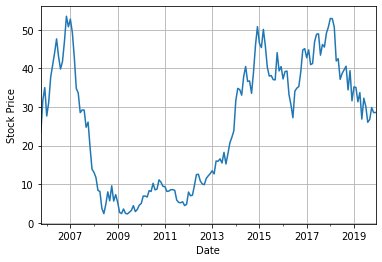

In [2]:
name = "AAl"

df = yf.download(tickers=name, start="2005-01-01", end="2020-01-01" ,interval="1mo", auto_adjust=True, prepost=False)
data = pd.Series(df["Close"])
data = data.dropna()

plt.ylabel("Stock Price")
data.plot()
plt.grid()


Splitting the data into a training and testing part.

In [3]:
allData = data.copy()
data = data[:int(data.size*0.85)]

View augmented Dickey-Fuller test, the data, PACF and PAC

(-0.7974610981276599, 0.8198667134386429, 0, 144, {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}, 652.6358544972416)


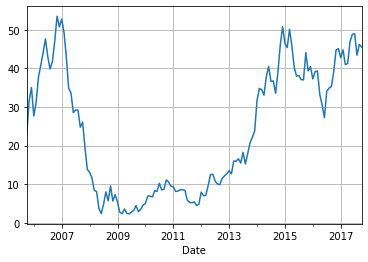

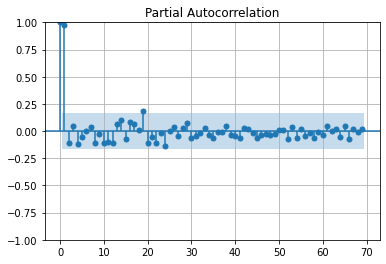

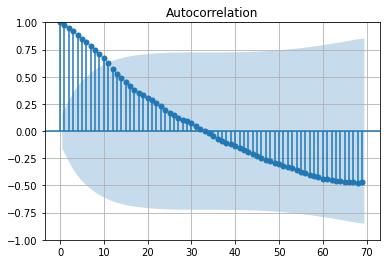

In [4]:
resAd = adfuller(data)
print(resAd)
data.plot()
plt.grid()
plot_pacf(data, method="ywm", lags=data.size/2.1);
plt.grid()
plot_acf(data, lags=data.size/2.1);
plt.grid()

View the same, but with differentiated data.

(-2.985867814454089, 0.03623541171287775, 13, 129, {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}, 652.2404949763104)


c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


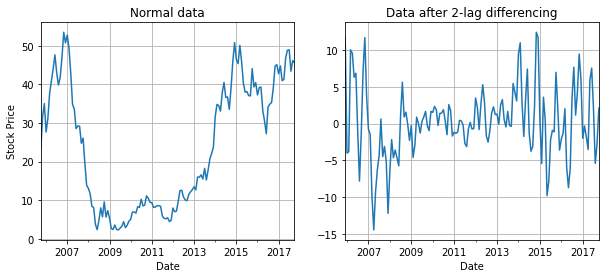

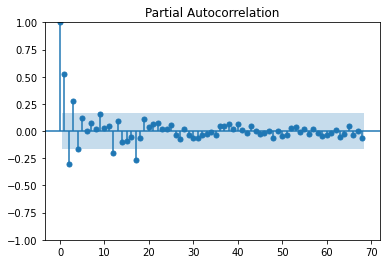

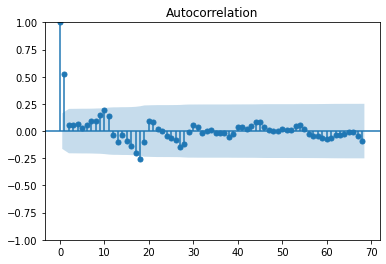

In [5]:
m = 2
diffData = data-data.shift(m)
diffData = diffData.dropna()

resAd = adfuller(diffData)
print(resAd)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.ylabel("Stock Price")
data.plot(title="Normal data")
plt.grid()
plt.subplot(1, 2, 2)
diffData.plot(title=f"Data after {m}-lag differencing")
plt.grid()
plot_pacf(diffData, method="ywm", lags=diffData.size/2.1)
plot_acf(diffData, lags=diffData.size/2.1);


Create an ARIMA model with specified parameters.

In [6]:
model = ARIMA(data, order=(4,2,1))
arima_fit = model.fit()
summary = arima_fit.summary()
print(summary)

c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  145
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -369.745
Date:                Sun, 15 May 2022   AIC                            751.490
Time:                        21:32:50   BIC                            769.267
Sample:                    10-01-2005   HQIC                           758.714
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1399      0.082      1.698      0.089      -0.022       0.301
ar.L2         -0.0384      0.079     -0.483      0.629      -0.194       0.117
ar.L3          0.0296      0.081      0.366      0.7

Plot and evaluate the model.

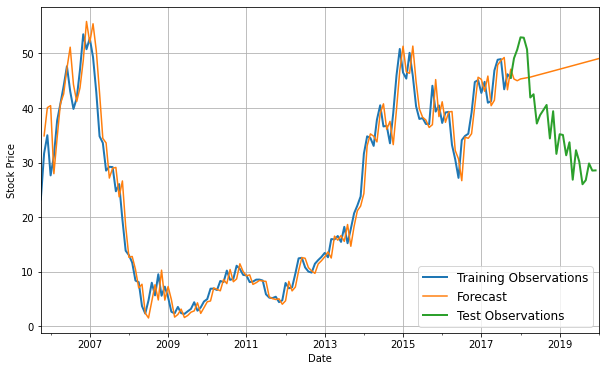

In [7]:
plt.figure(figsize=(10,6))
allData.iloc[:data.size].plot(linewidth=2, label="Training Observations")
arima_predict = arima_fit.predict(start=1, end=allData.size)
arima_predict.plot(label="Forecast")
allData.iloc[data.size-1:].plot(linewidth=2, label="Test Observations")
plt.ylabel("Stock Price")
plt.grid()
plt.legend(fontsize="12")


Brute force algortihm to find the best parameters for SARIMA by looking at the AIC value.

In [10]:
def getBestSeasonal(data,nonSeasPar=(1,1,1), P_max=4, D_max=2, Q_max=4):
    best_aic = np.inf
    bestSeasPar = [1, 1, 1]
    bestModel = ""
    for P in range(0, P_max+1):
        for D in range(1, D_max+1):
            for Q in range(0, Q_max+1):
                model = SARIMAX(data, order=nonSeasPar, seasonal_order=(P,D,Q,12), freq=data.index.inferred_freq)
                model_fit = model.fit()
                summary = model_fit.summary()
                info = pd.read_html(summary.tables[0].as_html())[0]
                aic = info[3][2]
                if best_aic > aic:
                    bestModel = f"{info[0][1]} {info[1][1]}, {info[2][2]}: {info[3][2]}"
                    best_aic = aic
                    bestSeasPar = [P, D, Q]
    print(bestModel)
    return bestSeasPar

In [ ]:
P,D,Q = getBestSeasonal(data,(4, 2, 1),3,2,3)

Create a SARIMA model with the new parameters and the nonseasonal from the ARIMA part.

In [12]:
print(f"P:{P}, D:{D}, Q:{Q}")
model = SARIMAX(data, order=(4,2,1), seasonal_order=(P,D,Q,12), freq=data.index.inferred_freq)
sarima_fit = model.fit(maxiter=200)
summary = sarima_fit.summary();
print(summary)

P:0, D:1, Q:1


c:\Users\Sigurd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  145
Model:             SARIMAX(4, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -353.475
Date:                            Sun, 15 May 2022   AIC                            720.950
Time:                                    21:35:16   BIC                            741.077
Sample:                                10-01-2005   HQIC                           729.129
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0024      0.123     -0.019      0.985      -0.244       0.239
ar.L2         -0.1391      0.106   

Plot and evaluate the model.

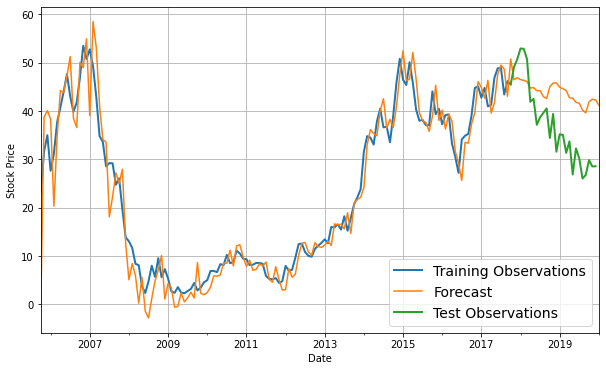

In [13]:
plt.figure(figsize=(10,6))
allData.iloc[:data.size].plot(linewidth=2, label="Training Observations")
sarima_predict = sarima_fit.predict(start=0, end=allData.size)
sarima_predict.plot(label="Forecast")
allData.iloc[data.size-1:].plot(linewidth=2, label="Test Observations")
plt.ylabel("Stock Price")
plt.grid()
plt.legend(fontsize="14")

Zoomed in plot of the one above to see more details.

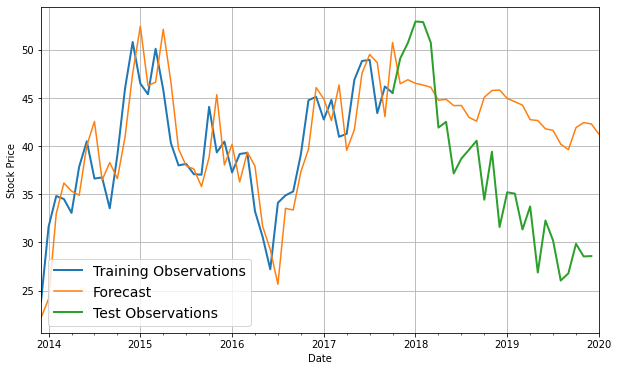

In [14]:
plt.figure(figsize=(10,6))
startingDate = int(12*8.2)
allData.iloc[startingDate:data.size].plot(linewidth=2, label="Training Observations")
sarima_predict = sarima_fit.predict(start=startingDate, end=allData.size)
sarima_predict.plot(label="Forecast")
allData.iloc[data.size-1:].plot(linewidth=2, label="Test Observations")
plt.ylabel("Stock Price")
plt.grid()
plt.legend(fontsize="14")